<a href="https://colab.research.google.com/github/layely/DeepLearning-Course-UdeM/blob/master/Ly_Keras_FaceRGB_Asian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Data preparation


## Authenticate to GDrive

In [0]:
# Code to read csv file into Colaboratory
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Download dataset (zip file)

In [0]:
import os

# Gdrive link of the dataset 
link = 'https://drive.google.com/open?id=1qINJkD-QOLTObanfIyVMK74yoa6Jins5'
  
_, id = link.split('=')

# Download if zip file does not exist
if os.path.isfile('FacesDataset.zip'):
  print("archive already downloaded")
else:
  print("Downloading dataset (FacesDataset.zip)...")
  downloaded = drive.CreateFile({'id':id})
  downloaded.GetContentFile('FacesDataset.zip')
  print("Donwload finished")

archive already downloaded


## Extract dataset archive

In [0]:
# Extract dataset archive
import zipfile

EXTRACT_PATH = "FacesDataset"

archive = zipfile.ZipFile('FacesDataset.zip', 'r')
archive.extractall(path=EXTRACT_PATH)


if os.path.isdir(EXTRACT_PATH):
  print("archive successfully extracted")
else:
  print("Can't extract archive")
  


archive successfully extracted


## Load dataset


Here we load entirely the dataset in ram since we can afford it. Though, in the other notebooks we load only a batch of images for each step. 

In [0]:
!cd FacesDataset && ls

FacesDataset


In [0]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from skimage.transform import resize

#bottle_resized = resize(bottle, (140, 54), anti_aliasing=True)

root_dir = EXTRACT_PATH + "/" + EXTRACT_PATH
races = ["Asian"]

for race in races:
  directory = root_dir + "/" + race
  imgs_gs = glob.glob(directory + "/" + race + "GS/*.jpg")
  imgs_rgb = glob.glob(directory + "/" + race + "RGB/*jpg")
  

# Check if we have the same number of images in both GS and RGB folders
# and images are in the same order
print("len gs %d, len rgb %d " % (len(imgs_gs), len(imgs_rgb)))

img_width = 256
img_height = 256

imgs_gs = np.array([resize(plt.imread(x), (img_width, img_height), anti_aliasing=True) for x in imgs_gs])
imgs_rgb = np.array([resize(plt.imread(x), (img_width, img_height), anti_aliasing=True) for x in imgs_rgb])

imgs_gs = np.expand_dims(imgs_gs, axis=3)

#print(imgs_rgb[0, :, :,])

print(imgs_gs.shape)
print(imgs_rgb.shape)

len gs 1284, len rgb 1284 


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(1284, 256, 256, 1)
(1284, 256, 256, 3)


## Split Dataset

The dataset is split as follows: 80% for trainig and 20% for test. Then we pick from the training 60 images for validation.

In [0]:
train_proportion = 0.8
num_train = int(imgs_gs.shape[0] * train_proportion)

imgs_gs_train = imgs_gs[0:num_train]
imgs_rgb_train = imgs_rgb[0:num_train]

imgs_gs_val = imgs_gs_train[0:60]
imgs_rgb_val = imgs_rgb_train[0:60]

imgs_gs_train = imgs_gs[60:]
imgs_rgb_train = imgs_rgb[60:]

imgs_gs_test = imgs_gs[num_train:]
imgs_rgb_test = imgs_rgb[num_train:]

print("Number of images in train set:", imgs_gs_train.shape[0])
print("Number of images in test set:", imgs_rgb_test.shape[0])

Number of images in train set: 1224
Number of images in test set: 257


## Show images from the dataset

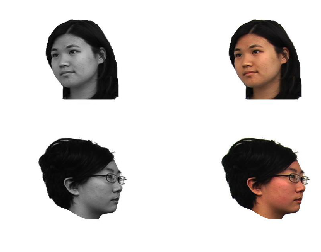

In [0]:
fig, axis = plt.subplots(2, 2)
cnt = 0
for i in range(2):
  axis[i,0].imshow(imgs_gs_train[cnt, :, :,0], cmap='gray')
  axis[i,0].axis('off')
  axis[i,1].imshow(imgs_rgb_train[cnt, :, :,])
  axis[i,1].axis('off')
  cnt += 1
plt.show()
plt.close()

# Discriminator

For the discriminator we choose a pretrained DenseNet. Then, we add a global average pooling followed by a fully connected layer with 64 neurons and activated by a leaky relu function. After this, follows a final fully connected layer with a softmax activation judging weither the image is fake or real. Before each fully connected we add 50% dropout. We tested also a network similator to the encoder part of our generator but the adversarial loss get stuck only after the first step of the training.


![Discriminator architecture](https://i.ibb.co/HnRk5TD/tp-dl-gan-generator-1.png)

In [0]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, LeakyReLU, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.initializers import VarianceScaling
from keras.applications.densenet import DenseNet121

def freeze_model(model, num_freeze=0):
  # Freeze layers the first 'num_freeze' layers 
  for layer in model.layers[:num_freeze]:
    layer.trainable = False
  for layer in model.layers[num_freeze:]:
    layer.trainable = True
    
def build_discriminator(img_shape=(256,256,3), dropout=0.5, verbose=False):
  base_model = DenseNet121(input_shape=img_shape, weights='imagenet', include_top=False)
  
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dropout(dropout)(x)
  x = Dense(64)(x)
  x = LeakyReLU()(x)
  x = Dropout(dropout)(x)
  y = Dense(1, activation='sigmoid')(x)
  
  model = Model(inputs=base_model.input, outputs=y)
  
  freeze_model(model, num_freeze=len(base_model.layers))
  
  if verbose:
    model.summary()
  
  return model
            
disc = build_discriminator(verbose=True)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormal

# Generator

![Texte alternatif…](https://i.ibb.co/fFNcGqx/generator-projet-dl.png)

The generator has two stages: an encoder and a decoder. Each encoding part consist of a convolution followed by a batch normatiliztaion and a leaky relu with alpha equal to 0.3. In each decoding part, we have an upsampling followed by a decovolution. We further concatenate the output of each deconvolution with the output of the symetric encoding block. Except, the last decoding block is concatenated with the grayscale image given as input. This architecture is choosen because it is memory efficient compared to a fully convNet that we also tested. The concatenation allows the network to keep track of the past feature and hence we have more realistic images in fewer steps. This mainly inspired from the UNet architecture.

A part from that, the outpout of our generator is activated with sigmoid instead of tanh. The only reason for this is to avoid having to normalize again the image in the range [0, 1].

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, Deconv2D, UpSampling2D, Cropping2D, BatchNormalization, LeakyReLU
from keras.layers import Activation, Reshape, Dropout, Dense, Flatten, concatenate
from keras.models import Input, Model

def encode(input_tensor, filters, strides=1, filter_size=5):
  x = Conv2D(filters, filter_size, strides=strides, padding='same')(input_tensor)
  y = BatchNormalization(momentum=0.9)(x)
  z = LeakyReLU(alpha=0.3)(y)
  return z

def decode(input_tensor, filters, filter_size=5, concat=None):
  x = UpSampling2D(size=(2,2))(input_tensor)
  y = Deconv2D(filters, filter_size, padding='same')(x)
  z = BatchNormalization(momentum=0.9)(y)
  t = LeakyReLU(alpha=0.3)(z)
  if concat == None:
    return t
  else:
    print(t.shape)
    print(concat.shape)
    return concatenate([concat, t])
  
def build_generator(imgs_shape=(img_width,img_height,1), dropout=0.4, verbose=False):
  grayscale = Input(shape=imgs_shape)
  
  # Encode
  e1 = encode(grayscale, 64, strides=2)
  e2 = encode(e1, 128, strides=2)
  e3 = encode(e2, 256, strides=2)
  e4 = encode(e3, 512, strides=2)
  
  # Decode
  d1 = decode(e4, 256, concat=e3)
  d2 = decode(d1, 128, concat=e2)
  d3 = decode(d2, 64, concat=e1)
  d4 = decode(d3, 32, concat=grayscale)
  
  rgb_1 = Conv2D(3, 5, strides=1, padding='same')(d4)
  rgb = Activation('sigmoid')(rgb_1)
  
  model = Model(grayscale, rgb)
            
  if verbose:
    model.summary()
  
  return model

gen = build_generator(verbose=True)
            

(?, ?, ?, 256)
(?, 32, 32, 256)
(?, ?, ?, 128)
(?, 64, 64, 128)
(?, ?, ?, 64)
(?, 128, 128, 64)
(?, ?, ?, 32)
(?, 256, 256, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 1664        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_2 (LeakyReLU)       (None, 128, 128, 64) 0           batch_normalizat

# Show generated images

This function allows us to show 4 imagesto monitor our generator perforcemance during training.

In [0]:
import matplotlib.pyplot as plt

def sample_images(epoch, generator, imgs_gs):
  r, c = 2, 2
  gen_imgs = generator.predict(imgs_gs[0:r*c])
  
  fig, axis = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      axis[i,j].imshow(gen_imgs[cnt, :, :,])
      axis[i,j].axis('off')
      cnt += 1
  plt.show()
  plt.close()

# Init Hyperparams

Here we use a batch size of 16 and 500 iteration suffice to  have very good results as it can be seen bellow. We tested Adam an RMSprop by the results were also pretty similar.

In [0]:
from keras.optimizers import RMSprop, Adam

batch_size = 16
epochs = 500 #5000

# discriminator params
d_lr = 0.9 #.0008
d_decay = 6e-8
d_optimizer = Adam(lr=d_lr, decay=d_decay) #RMSprop(lr=d_lr, clipvalue=1.0, decay=d_decay)

# adversarial params
a_lr = 0.0002
a_decay = 3e-8
a_optimizer = Adam(lr=a_lr, decay=a_decay) #RMSprop(lr=a_lr, clipvalue=1.0, decay=a_decay)


# Combine Generator and Discriminator

Here we create the combined model which have two ouputs, a classification value (fake or real) from the discriminator and the generated images from the generator. We also combined two losses (binary crossentropy and mse), this is mainly inspired from SRGAN. At the begining we tried using only a binary crossentropy loss and it didn't work as the generator was not learning anything. The discriminator is only compiled with a binary crossentropy loss and is freezed before plugged to the combined network. 

In [0]:


from keras.models import Model
from keras.layers import concatenate, Input
from keras.applications.densenet import preprocess_input

# Build and compile discriminator
discriminator = build_discriminator((img_width, img_height, 3))
discriminator.compile(loss='binary_crossentropy',
                      optimizer=d_optimizer,
                      metrics=['accuracy'])


# build generator
generator = build_generator(imgs_shape=(img_width, img_height, 1))
#generator.compile(loss='mae', optimizer=a_optimizer, metrics=['accuracy'])

# generator takes noise and return img
gs_image = Input(shape=(img_width,img_height,1))
rgb_image = generator(gs_image)

# Freeze discriminator when combined with generator
discriminator.trainable = False

# discriminator takes generated images as input and determines validity
validity = discriminator(rgb_image)

# combine models
adversarial = Sequential()
adversarial = Model(gs_image, [validity, rgb_image])
adversarial.compile(loss=['binary_crossentropy', 'mse'], 
                    loss_weights=[1, 1], 
                    optimizer=a_optimizer)

(?, ?, ?, 256)
(?, 32, 32, 256)
(?, ?, ?, 128)
(?, 64, 64, 128)
(?, ?, ?, 64)
(?, 128, 128, 64)
(?, ?, ?, 32)
(?, 256, 256, 1)


# Adversarial Training

Here we run the training and save the losses. We also used a validation set of 60 images to monitor our generator performance on unseen images. We use the mse loss to save the best model.

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


60/60 [==============================] - 14s 229ms/step
[0.06933418214321137, 1.192093321833454e-07, 0.06933406293392182]
d_real: [0.5856209, 0.625]
d_fake: [14.945986, 0.0625]
0/500 [D loss: 7.765803, acc.: 34.38%] [G loss mse: 2.214520] [G loss bce: 2.014762]


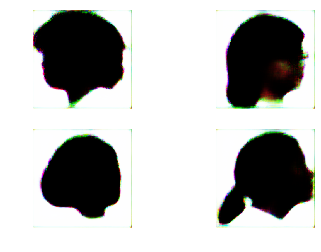

60/60 [==============================] - 1s 16ms/step
[0.034862244874238967, 1.192093321833454e-07, 0.034862125664949416]
60/60 [==============================] - 1s 16ms/step
[0.02882078414162, 1.192093321833454e-07, 0.02882066493233045]
60/60 [==============================] - 1s 16ms/step
[0.02589627243578434, 1.192093321833454e-07, 0.02589615322649479]
60/60 [==============================] - 1s 17ms/step
[0.02222995087504387, 1.192093321833454e-07, 0.022229831665754318]
60/60 [==============================] - 1s 17ms/step
[0.019974229981501897, 1.192093321833454e-07, 0.019974110772212346]
60/60 [==============================] - 1s 17ms/step
[0.018964860464135806, 1.192093321833454e-07, 0.018964741254846255]
60/60 [==============================] - 1s 17ms/step
[0.01937027449409167, 1.192093321833454e-07, 0.01937015528480212]
60/60 [==============================] - 1s 17ms/step
[0.01571698443343242, 1.192093321833454e-07, 0.01571686522414287]
60/60 [=============================

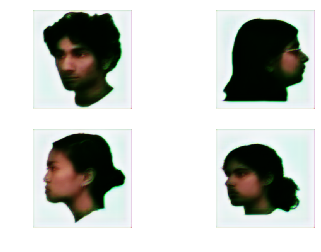

60/60 [==============================] - 1s 17ms/step
[0.011081753795345624, 1.192093321833454e-07, 0.011081634586056073]
60/60 [==============================] - 1s 17ms/step
[0.009812202552954357, 1.192093321833454e-07, 0.009812083343664806]
60/60 [==============================] - 1s 16ms/step
[0.009498559807737669, 1.192093321833454e-07, 0.009498440598448118]
60/60 [==============================] - 1s 16ms/step
[0.009363323574264844, 1.192093321833454e-07, 0.009363204364975293]
60/60 [==============================] - 1s 16ms/step
[0.009021599466602007, 1.192093321833454e-07, 0.009021480257312456]
60/60 [==============================] - 1s 16ms/step
[0.008913383694986503, 1.192093321833454e-07, 0.008913264485696952]
60/60 [==============================] - 1s 16ms/step
[0.008452198033531507, 1.192093321833454e-07, 0.008452078824241956]
60/60 [==============================] - 1s 16ms/step
[0.007561317645013332, 1.192093321833454e-07, 0.007561198435723782]
60/60 [=================

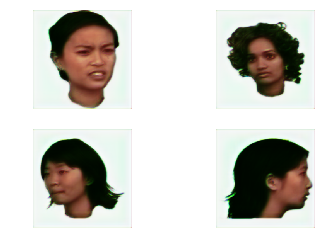

60/60 [==============================] - 1s 16ms/step
[0.006403094964722792, 1.192093321833454e-07, 0.006402975755433241]
60/60 [==============================] - 1s 16ms/step
[0.00622583848113815, 1.192093321833454e-07, 0.006225719271848599]
60/60 [==============================] - 1s 16ms/step
[0.006321907136589288, 1.192093321833454e-07, 0.006321787927299738]
60/60 [==============================] - 1s 16ms/step
[0.006599820218980312, 1.192093321833454e-07, 0.0065997010096907616]
60/60 [==============================] - 1s 16ms/step
[0.007021559278170267, 1.192093321833454e-07, 0.0070214400688807166]
60/60 [==============================] - 1s 16ms/step
[0.006489463988691569, 1.192093321833454e-07, 0.006489344779402018]
60/60 [==============================] - 1s 16ms/step
[0.005315481467793385, 1.192093321833454e-07, 0.005315362258503834]
60/60 [==============================] - 1s 16ms/step
[0.004819401415685812, 1.192093321833454e-07, 0.0048192822063962614]
60/60 [===============

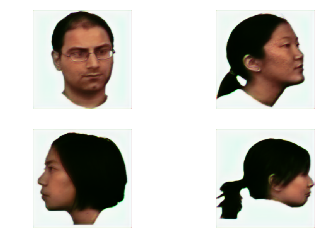

60/60 [==============================] - 1s 16ms/step
[0.004478201859941086, 1.192093321833454e-07, 0.004478082650651535]
60/60 [==============================] - 1s 16ms/step
[0.004346946657945713, 1.192093321833454e-07, 0.004346827448656162]
60/60 [==============================] - 1s 16ms/step
[0.004157231841236353, 1.192093321833454e-07, 0.004157112631946802]
60/60 [==============================] - 1s 16ms/step
[0.0038883365380267304, 1.192093321833454e-07, 0.0038882173287371796]
60/60 [==============================] - 1s 16ms/step
[0.003646381696065267, 1.192093321833454e-07, 0.003646262486775716]
60/60 [==============================] - 1s 16ms/step
[0.0034992833777020373, 1.192093321833454e-07, 0.0034991641684124866]
60/60 [==============================] - 1s 16ms/step
[0.0036873480615516505, 1.192093321833454e-07, 0.0036872288522620997]
60/60 [==============================] - 1s 16ms/step
[0.0038587657113869985, 1.192093321833454e-07, 0.0038586465020974477]
60/60 [=========

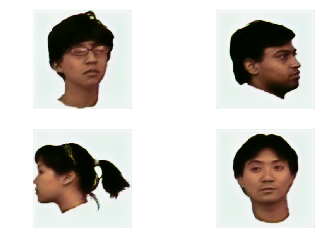

60/60 [==============================] - 1s 16ms/step
[0.004497690312564373, 1.192093321833454e-07, 0.004497571103274822]
60/60 [==============================] - 1s 16ms/step
[0.004343035599837701, 1.192093321833454e-07, 0.00434291639054815]
60/60 [==============================] - 1s 16ms/step
[0.003999178173641363, 1.192093321833454e-07, 0.003999058964351813]
60/60 [==============================] - 1s 16ms/step
[0.0034841546944032113, 1.192093321833454e-07, 0.0034840354851136605]
60/60 [==============================] - 1s 16ms/step
[0.003346959020321568, 1.192093321833454e-07, 0.003346839811032017]
60/60 [==============================] - 1s 16ms/step
[0.002852981366838018, 1.192093321833454e-07, 0.002852862157548467]
60/60 [==============================] - 1s 16ms/step
[0.0027037832575539746, 1.192093321833454e-07, 0.002703664048264424]
60/60 [==============================] - 1s 16ms/step
[0.0029472698302318652, 1.192093321833454e-07, 0.0029471506209423144]
60/60 [=============

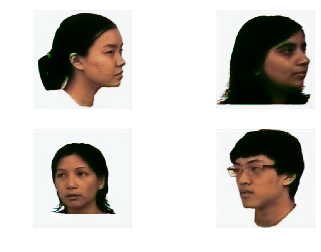

60/60 [==============================] - 1s 16ms/step
[0.003501550853252411, 1.192093321833454e-07, 0.00350143164396286]
60/60 [==============================] - 1s 16ms/step
[0.003551419901972016, 1.192093321833454e-07, 0.003551300692682465]
60/60 [==============================] - 1s 16ms/step
[0.003117436341320475, 1.192093321833454e-07, 0.003117317132030924]
60/60 [==============================] - 1s 16ms/step
[0.0027916282260169586, 1.192093321833454e-07, 0.002791509016727408]
60/60 [==============================] - 1s 16ms/step
[0.00259014330804348, 1.192093321833454e-07, 0.0025900240987539293]
60/60 [==============================] - 1s 16ms/step
[0.002228317487364014, 1.192093321833454e-07, 0.002228198278074463]
60/60 [==============================] - 1s 16ms/step
[0.002029992671062549, 1.192093321833454e-07, 0.002029873461772998]
60/60 [==============================] - 1s 16ms/step
[0.001978026314948996, 1.192093321833454e-07, 0.0019779071056594453]
60/60 [================

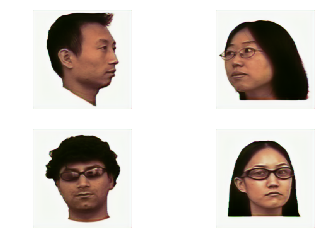

60/60 [==============================] - 1s 16ms/step
[0.002323072139794628, 1.192093321833454e-07, 0.002322952930505077]
60/60 [==============================] - 1s 16ms/step
[0.0029686791046212115, 1.192093321833454e-07, 0.0029685598953316608]
60/60 [==============================] - 1s 16ms/step
[0.0032286735717207194, 1.192093321833454e-07, 0.0032285543624311686]
60/60 [==============================] - 1s 16ms/step
[0.0028680938916901748, 1.192093321833454e-07, 0.002867974682400624]
60/60 [==============================] - 1s 16ms/step
[0.0023051848790297904, 1.192093321833454e-07, 0.0023050656697402396]
60/60 [==============================] - 1s 16ms/step
[0.0020304424688220024, 1.192093321833454e-07, 0.0020303232595324516]
60/60 [==============================] - 1s 16ms/step
[0.0018372148275375365, 1.192093321833454e-07, 0.0018370956182479858]
60/60 [==============================] - 1s 16ms/step
[0.0017462087251866856, 1.192093321833454e-07, 0.0017460895158971348]
60/60 [====

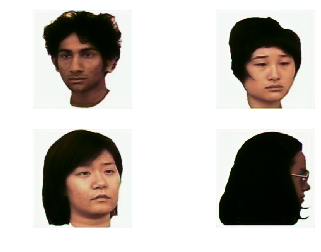

60/60 [==============================] - 1s 16ms/step
[0.003249381280814608, 1.192093321833454e-07, 0.0032492620715250573]
60/60 [==============================] - 1s 16ms/step
[0.003684712868804733, 1.192093321833454e-07, 0.0036845936595151824]
60/60 [==============================] - 1s 16ms/step
[0.0038302348461002112, 1.192093321833454e-07, 0.0038301156368106604]
60/60 [==============================] - 1s 16ms/step
[0.0038737754803150892, 1.192093321833454e-07, 0.0038736562710255384]
60/60 [==============================] - 1s 16ms/step
[0.003736828888456027, 1.192093321833454e-07, 0.003736709679166476]
60/60 [==============================] - 1s 16ms/step
[0.0034203791214774053, 1.192093321833454e-07, 0.0034202599121878545]
60/60 [==============================] - 1s 16ms/step
[0.002806200971826911, 1.192093321833454e-07, 0.0028060817625373603]
60/60 [==============================] - 1s 16ms/step
[0.0023705709259957074, 1.192093321833454e-07, 0.0023704517167061566]
60/60 [======

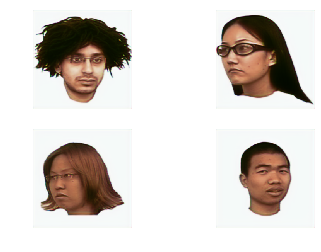

60/60 [==============================] - 1s 16ms/step
[0.0016635247195760409, 1.192093321833454e-07, 0.00166340551028649]
60/60 [==============================] - 1s 16ms/step
[0.0016067062116538486, 1.192093321833454e-07, 0.0016065870023642978]
60/60 [==============================] - 1s 16ms/step
[0.0016237646574154495, 1.192093321833454e-07, 0.0016236454481258988]
60/60 [==============================] - 1s 16ms/step
[0.0015913519853105148, 1.192093321833454e-07, 0.001591232776020964]
60/60 [==============================] - 1s 16ms/step
[0.0015063898249839743, 1.192093321833454e-07, 0.0015062706156944235]
60/60 [==============================] - 1s 16ms/step
[0.001484357200873395, 1.192093321833454e-07, 0.0014842379915838441]
60/60 [==============================] - 1s 16ms/step
[0.0014370670076459646, 1.192093321833454e-07, 0.0014369477983564138]
60/60 [==============================] - 1s 16ms/step
[0.0013965606689453126, 1.192093321833454e-07, 0.0013964414596557618]
60/60 [=====

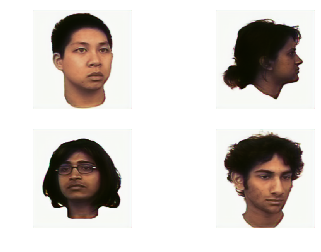

60/60 [==============================] - 1s 16ms/step
[0.0015320732180650035, 1.192093321833454e-07, 0.0015319540087754527]
60/60 [==============================] - 1s 16ms/step
[0.0016150128251562516, 1.192093321833454e-07, 0.0016148936158667008]
60/60 [==============================] - 1s 16ms/step
[0.0016296383381510773, 1.192093321833454e-07, 0.0016295191288615265]
60/60 [==============================] - 1s 16ms/step
[0.0016285833980267247, 1.192093321833454e-07, 0.001628464188737174]
60/60 [==============================] - 1s 16ms/step
[0.0015876305134346089, 1.192093321833454e-07, 0.001587511304145058]
60/60 [==============================] - 1s 16ms/step
[0.0015931931712354222, 1.192093321833454e-07, 0.0015930739619458715]
60/60 [==============================] - 1s 16ms/step
[0.001557266393986841, 1.192093321833454e-07, 0.0015571471846972903]
60/60 [==============================] - 1s 16ms/step
[0.0014591961478193601, 1.192093321833454e-07, 0.0014590769385298093]
60/60 [====

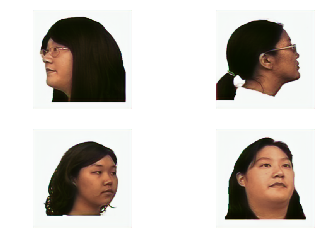

60/60 [==============================] - 1s 16ms/step
[0.0012836847919970751, 1.192093321833454e-07, 0.0012835655827075243]
60/60 [==============================] - 1s 16ms/step
[0.001259926970427235, 1.192093321833454e-07, 0.0012598077611376843]
60/60 [==============================] - 1s 16ms/step
[0.0012386916127676765, 1.192093321833454e-07, 0.0012385724034781258]
60/60 [==============================] - 1s 16ms/step
[0.00124538690627863, 1.192093321833454e-07, 0.0012452676969890793]
60/60 [==============================] - 1s 16ms/step
[0.001246469219525655, 1.192093321833454e-07, 0.0012463500102361043]
60/60 [==============================] - 1s 16ms/step
[0.0012449206008265416, 1.192093321833454e-07, 0.0012448013915369908]
60/60 [==============================] - 1s 16ms/step
[0.0012344980457176765, 1.192093321833454e-07, 0.0012343788364281257]
60/60 [==============================] - 1s 16ms/step
[0.0012579023217161496, 1.192093321833454e-07, 0.0012577831124265988]
60/60 [=====

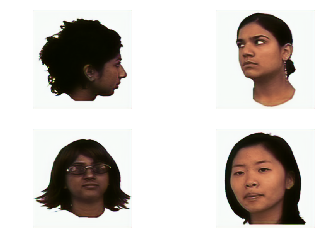

60/60 [==============================] - 1s 16ms/step
[0.0012997140098984044, 1.192093321833454e-07, 0.0012995948006088536]
60/60 [==============================] - 1s 16ms/step
[0.00126097258956482, 1.192093321833454e-07, 0.0012608533802752693]
60/60 [==============================] - 1s 16ms/step
[0.0012528140097856522, 1.192093321833454e-07, 0.0012526948004961014]
60/60 [==============================] - 1s 16ms/step
[0.0012468297422553102, 1.192093321833454e-07, 0.0012467105329657595]
60/60 [==============================] - 1s 16ms/step
[0.00115518468276908, 1.192093321833454e-07, 0.0011550654734795293]
60/60 [==============================] - 1s 16ms/step
[0.0011086555353055398, 1.192093321833454e-07, 0.001108536326015989]
60/60 [==============================] - 1s 16ms/step
[0.0010911065541828672, 1.192093321833454e-07, 0.0010909873448933165]
60/60 [==============================] - 1s 16ms/step
[0.0010728242030988136, 1.192093321833454e-07, 0.0010727049938092628]
60/60 [======

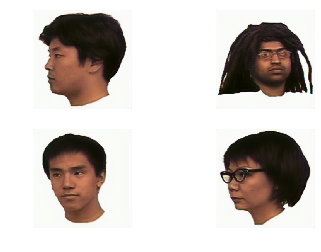

60/60 [==============================] - 1s 16ms/step
[0.0013319210847839713, 1.192093321833454e-07, 0.0013318018754944205]
60/60 [==============================] - 1s 16ms/step
[0.0016416605173920592, 1.192093321833454e-07, 0.0016415413081025084]
60/60 [==============================] - 1s 16ms/step
[0.0017981683602556586, 1.192093321833454e-07, 0.0017980491509661078]
60/60 [==============================] - 1s 16ms/step
[0.0019224859618892272, 1.192093321833454e-07, 0.0019223667525996764]
60/60 [==============================] - 1s 16ms/step
[0.0017996299313381315, 1.192093321833454e-07, 0.0017995107220485807]
60/60 [==============================] - 1s 16ms/step
[0.0015535801261042554, 1.192093321833454e-07, 0.0015534609168147047]
60/60 [==============================] - 1s 16ms/step
[0.001368850803313156, 1.192093321833454e-07, 0.0013687315940236052]
60/60 [==============================] - 1s 16ms/step
[0.0010331463456774751, 1.192093321833454e-07, 0.0010330271363879243]
60/60 [==

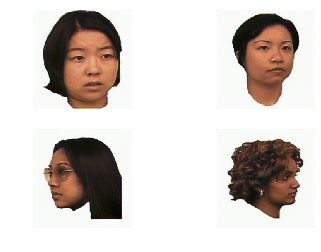

60/60 [==============================] - 1s 16ms/step
[0.001001714604596297, 1.192093321833454e-07, 0.0010015953953067462]
60/60 [==============================] - 1s 16ms/step
[0.0010709371883422137, 1.192093321833454e-07, 0.001070817979052663]
60/60 [==============================] - 1s 16ms/step
[0.0011801767706250152, 1.192093321833454e-07, 0.0011800575613354644]
60/60 [==============================] - 1s 16ms/step
[0.0012635931372642518, 1.192093321833454e-07, 0.001263473927974701]
60/60 [==============================] - 1s 16ms/step
[0.0011594924998159209, 1.192093321833454e-07, 0.00115937329052637]
60/60 [==============================] - 1s 16ms/step
[0.0011112297186627984, 1.192093321833454e-07, 0.0011111105093732476]
60/60 [==============================] - 1s 16ms/step
[0.0010728471757223208, 1.192093321833454e-07, 0.00107272796643277]
60/60 [==============================] - 1s 16ms/step
[0.0010721602865184346, 1.192093321833454e-07, 0.0010720410772288838]
60/60 [========

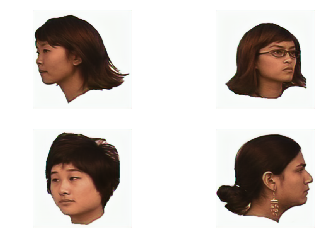

60/60 [==============================] - 1s 16ms/step
[0.001195340456130604, 1.192093321833454e-07, 0.0011952212468410532]
60/60 [==============================] - 1s 16ms/step
[0.0011354061542078852, 1.192093321833454e-07, 0.0011352869449183344]
60/60 [==============================] - 1s 16ms/step
[0.0010125165184338887, 1.192093321833454e-07, 0.001012397309144338]
60/60 [==============================] - 1s 16ms/step
[0.0009249217148559789, 1.192093321833454e-07, 0.0009248025055664281]
60/60 [==============================] - 1s 16ms/step
[0.0009827656128133337, 1.192093321833454e-07, 0.000982646403523783]
60/60 [==============================] - 1s 16ms/step
[0.001383293924542765, 1.192093321833454e-07, 0.0013831747152532141]
60/60 [==============================] - 1s 16ms/step
[0.0018750188096115987, 1.192093321833454e-07, 0.001874899600322048]
60/60 [==============================] - 1s 16ms/step
[0.0018072258215397596, 1.192093321833454e-07, 0.0018071066122502088]
60/60 [======

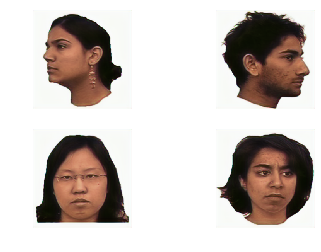

60/60 [==============================] - 1s 16ms/step
[0.0010525589110329746, 1.192093321833454e-07, 0.0010524397017434239]
60/60 [==============================] - 1s 16ms/step
[0.0010864693205803633, 1.192093321833454e-07, 0.0010863501112908125]
60/60 [==============================] - 1s 16ms/step
[0.0011019365939622125, 1.192093321833454e-07, 0.0011018173846726617]
60/60 [==============================] - 1s 16ms/step
[0.0010754439203689496, 1.192093321833454e-07, 0.0010753247110793988]
60/60 [==============================] - 1s 16ms/step
[0.0010072251626600823, 1.192093321833454e-07, 0.0010071059533705315]
60/60 [==============================] - 1s 16ms/step
[0.0009420417443228265, 1.192093321833454e-07, 0.0009419225350332757]
60/60 [==============================] - 1s 16ms/step
[0.0008912019974862535, 1.192093321833454e-07, 0.0008910827881967027]
60/60 [==============================] - 1s 16ms/step
[0.00084925014913703, 1.192093321833454e-07, 0.0008491309398474793]
60/60 [===

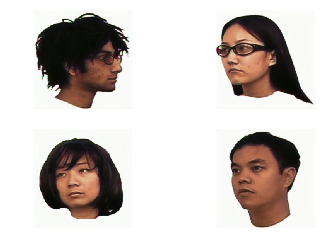

60/60 [==============================] - 1s 16ms/step
[0.0010021734323042133, 1.192093321833454e-07, 0.0010020542230146626]
60/60 [==============================] - 1s 16ms/step
[0.001027892273850739, 1.192093321833454e-07, 0.0010277730645611883]
60/60 [==============================] - 1s 16ms/step
[0.0010090932909709712, 1.192093321833454e-07, 0.0010089740816814205]
60/60 [==============================] - 1s 16ms/step
[0.0009464728840005895, 1.192093321833454e-07, 0.0009463536747110387]
60/60 [==============================] - 1s 16ms/step
[0.0009029134875163436, 1.192093321833454e-07, 0.0009027942782267928]
60/60 [==============================] - 1s 16ms/step
[0.0009085760839904349, 1.192093321833454e-07, 0.0009084568747008841]
60/60 [==============================] - 1s 16ms/step
[0.0009007646508204441, 1.192093321833454e-07, 0.0009006454415308933]
60/60 [==============================] - 1s 16ms/step
[0.0008699952197882036, 1.192093321833454e-07, 0.0008698760104986528]
60/60 [==

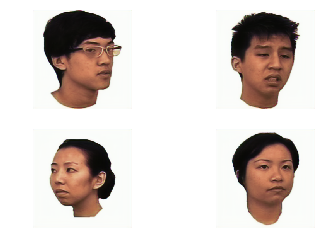

60/60 [==============================] - 1s 16ms/step
[0.0009363422209086518, 1.192093321833454e-07, 0.000936223011619101]
60/60 [==============================] - 1s 16ms/step
[0.0010323387493068974, 1.192093321833454e-07, 0.0010322195400173466]
60/60 [==============================] - 1s 16ms/step
[0.0010977226154257854, 1.192093321833454e-07, 0.0010976034061362346]
60/60 [==============================] - 1s 16ms/step
[0.001141518889926374, 1.192093321833454e-07, 0.0011413996806368231]
60/60 [==============================] - 1s 16ms/step
[0.0011979556487252314, 1.192093321833454e-07, 0.0011978364394356806]
60/60 [==============================] - 1s 16ms/step
[0.0012394974861914914, 1.192093321833454e-07, 0.0012393782769019406]
60/60 [==============================] - 1s 16ms/step
[0.0012215540511533618, 1.192093321833454e-07, 0.001221434841863811]
60/60 [==============================] - 1s 16ms/step
[0.001229169243015349, 1.192093321833454e-07, 0.0012290500337257982]
60/60 [=====

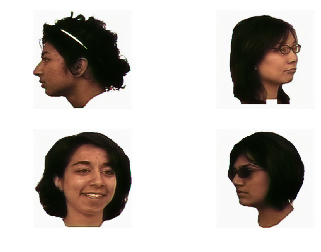

60/60 [==============================] - 1s 16ms/step
[0.0009404082355710367, 1.192093321833454e-07, 0.000940289026281486]
60/60 [==============================] - 1s 16ms/step
[0.0008541150329013665, 1.192093321833454e-07, 0.0008539958236118158]
60/60 [==============================] - 1s 16ms/step
[0.0008312827053790291, 1.192093321833454e-07, 0.0008311634960894783]
60/60 [==============================] - 1s 16ms/step
[0.000813752591299514, 1.192093321833454e-07, 0.0008136333820099632]
60/60 [==============================] - 1s 16ms/step
[0.0007985311560332776, 1.192093321833454e-07, 0.0007984119467437268]
60/60 [==============================] - 1s 16ms/step
[0.0007733500135752062, 1.192093321833454e-07, 0.0007732308042856554]
60/60 [==============================] - 1s 16ms/step
[0.0007496907647388677, 1.192093321833454e-07, 0.000749571555449317]
60/60 [==============================] - 1s 16ms/step
[0.0007440259020465115, 1.192093321833454e-07, 0.0007439066927569608]
60/60 [====

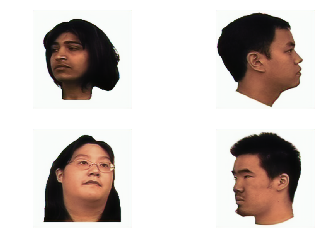

60/60 [==============================] - 1s 16ms/step
[0.0008550192889136573, 1.192093321833454e-07, 0.0008549000796241065]
60/60 [==============================] - 1s 16ms/step
[0.0008532760936456422, 1.192093321833454e-07, 0.0008531568843560914]
60/60 [==============================] - 1s 16ms/step
[0.0008239243878051638, 1.192093321833454e-07, 0.000823805178515613]
60/60 [==============================] - 1s 16ms/step
[0.0008507562063944837, 1.192093321833454e-07, 0.0008506369971049329]
60/60 [==============================] - 1s 16ms/step
[0.000851650497255226, 1.192093321833454e-07, 0.0008515312879656752]
60/60 [==============================] - 1s 16ms/step
[0.0008974784247887631, 1.192093321833454e-07, 0.0008973592154992124]
60/60 [==============================] - 1s 16ms/step
[0.0009452683230241139, 1.192093321833454e-07, 0.0009451491137345632]
60/60 [==============================] - 1s 16ms/step
[0.0009019934339448809, 1.192093321833454e-07, 0.0009018742246553301]
60/60 [===

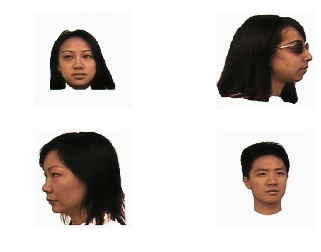

60/60 [==============================] - 1s 16ms/step
[0.0007760657113976777, 1.192093321833454e-07, 0.0007759465021081269]
60/60 [==============================] - 1s 16ms/step
[0.0007929374075805148, 1.192093321833454e-07, 0.000792818198290964]
60/60 [==============================] - 1s 16ms/step
[0.0008311215477685134, 1.192093321833454e-07, 0.0008310023384789626]
60/60 [==============================] - 1s 16ms/step
[0.0008923562631631891, 1.192093321833454e-07, 0.0008922370538736383]
60/60 [==============================] - 1s 16ms/step
[0.0009134516624423365, 1.192093321833454e-07, 0.0009133324531527857]
60/60 [==============================] - 1s 16ms/step
[0.0009295602600711087, 1.192093321833454e-07, 0.0009294410507815579]
60/60 [==============================] - 1s 16ms/step
[0.000872881345761319, 1.192093321833454e-07, 0.0008727621364717683]
60/60 [==============================] - 1s 16ms/step
[0.0008225400078420837, 1.192093321833454e-07, 0.0008224207985525329]
60/60 [===

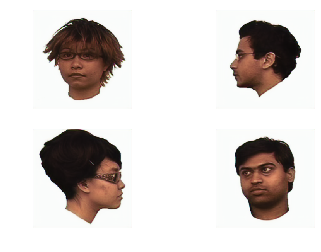

60/60 [==============================] - 1s 16ms/step
[0.0006805435521528124, 1.192093321833454e-07, 0.0006804243428632617]
60/60 [==============================] - 1s 16ms/step
[0.0007113901354993383, 1.192093321833454e-07, 0.0007112709262097875]
60/60 [==============================] - 1s 16ms/step
[0.0007749020820483566, 1.192093321833454e-07, 0.0007747828727588058]
60/60 [==============================] - 1s 16ms/step
[0.0007791748348002632, 1.192093321833454e-07, 0.0007790556255107124]
60/60 [==============================] - 1s 16ms/step
[0.0007699035961801807, 1.192093321833454e-07, 0.0007697843868906299]
60/60 [==============================] - 1s 16ms/step
[0.0007279301372667154, 1.192093321833454e-07, 0.0007278109279771646]
60/60 [==============================] - 1s 16ms/step
[0.0006999327374311785, 1.192093321833454e-07, 0.0006998135281416277]
60/60 [==============================] - 1s 16ms/step
[0.0007817522234593829, 1.192093321833454e-07, 0.0007816330141698321]
60/60 [=

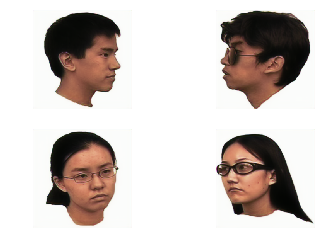

60/60 [==============================] - 1s 16ms/step
[0.0009816650301218033, 1.192093321833454e-07, 0.0009815458208322525]
60/60 [==============================] - 1s 16ms/step
[0.001158051542006433, 1.192093321833454e-07, 0.0011579323327168822]
60/60 [==============================] - 1s 16ms/step
[0.001096182355346779, 1.192093321833454e-07, 0.0010960631460572281]
60/60 [==============================] - 1s 16ms/step
[0.0009186467815500994, 1.192093321833454e-07, 0.0009185275722605487]
60/60 [==============================] - 1s 16ms/step
[0.0006953408398355047, 1.192093321833454e-07, 0.0006952216305459539]
60/60 [==============================] - 1s 16ms/step
[0.0006509482356098791, 1.192093321833454e-07, 0.0006508290263203283]
60/60 [==============================] - 1s 16ms/step
[0.0006672042538411916, 1.192093321833454e-07, 0.0006670850445516408]
60/60 [==============================] - 1s 16ms/step
[0.000657234286578993, 1.192093321833454e-07, 0.0006571150772894422]
60/60 [====

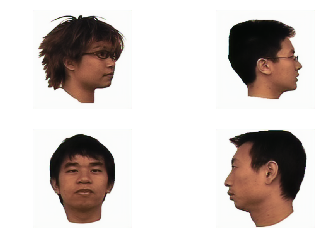

60/60 [==============================] - 1s 16ms/step
[0.0008767879994896551, 1.192093321833454e-07, 0.0008766687902001043]
60/60 [==============================] - 1s 16ms/step
[0.0010846143200372656, 1.192093321833454e-07, 0.0010844951107477148]
60/60 [==============================] - 1s 16ms/step
[0.0011953961181764801, 1.192093321833454e-07, 0.0011952769088869294]
60/60 [==============================] - 1s 16ms/step
[0.0012006475124508142, 1.192093321833454e-07, 0.0012005283031612634]
60/60 [==============================] - 1s 16ms/step
[0.0011284606143211326, 1.192093321833454e-07, 0.0011283414050315818]
60/60 [==============================] - 1s 16ms/step
[0.0009197252880161007, 1.192093321833454e-07, 0.0009196060787265499]
60/60 [==============================] - 1s 16ms/step
[0.0006820855545811355, 1.192093321833454e-07, 0.0006819663452915847]
60/60 [==============================] - 1s 16ms/step
[0.0006478800826395551, 1.192093321833454e-07, 0.0006477608733500043]
60/60 [=

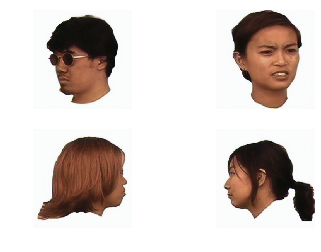

60/60 [==============================] - 1s 16ms/step
[0.0007023106057507297, 1.192093321833454e-07, 0.0007021913964611789]
60/60 [==============================] - 1s 16ms/step
[0.0007075867344004412, 1.192093321833454e-07, 0.0007074675251108905]
60/60 [==============================] - 1s 16ms/step
[0.0007212660158984364, 1.192093321833454e-07, 0.0007211468066088856]
60/60 [==============================] - 1s 16ms/step
[0.0007126570446416736, 1.192093321833454e-07, 0.0007125378353521228]
60/60 [==============================] - 1s 16ms/step
[0.000777086615562439, 1.192093321833454e-07, 0.0007769674062728882]
60/60 [==============================] - 1s 16ms/step
[0.0008144214671726029, 1.192093321833454e-07, 0.0008143022578830521]
60/60 [==============================] - 1s 16ms/step
[0.0008122019392127792, 1.192093321833454e-07, 0.0008120827299232284]
60/60 [==============================] - 1s 16ms/step
[0.0007349239623484512, 1.192093321833454e-07, 0.0007348047530589004]
60/60 [==

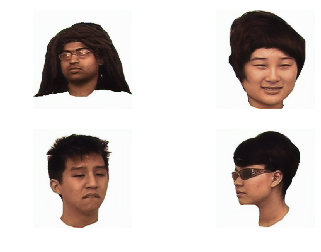

60/60 [==============================] - 1s 16ms/step
[0.0006333519743445019, 1.192093321833454e-07, 0.0006332327650549511]
60/60 [==============================] - 1s 16ms/step
[0.0006238695117644965, 1.192093321833454e-07, 0.0006237503024749458]
60/60 [==============================] - 1s 16ms/step
[0.0006439369598714013, 1.192093321833454e-07, 0.0006438177505818506]
60/60 [==============================] - 1s 16ms/step
[0.0007700947617801528, 1.192093321833454e-07, 0.000769975552490602]
60/60 [==============================] - 1s 16ms/step
[0.0009188397205434739, 1.192093321833454e-07, 0.0009187205112539231]
60/60 [==============================] - 1s 16ms/step
[0.0009517387098943194, 1.192093321833454e-07, 0.0009516195006047686]
60/60 [==============================] - 1s 16ms/step
[0.0008474917151033879, 1.192093321833454e-07, 0.0008473725058138371]
60/60 [==============================] - 1s 16ms/step
[0.000742844503838569, 1.192093321833454e-07, 0.0007427252945490182]
60/60 [===

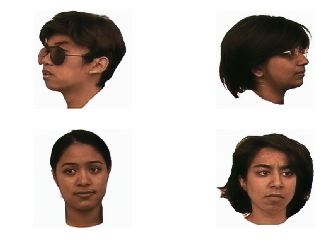

60/60 [==============================] - 1s 16ms/step
[0.0006881709094159305, 1.192093321833454e-07, 0.0006880517001263797]
60/60 [==============================] - 1s 16ms/step
[0.0007866869874609013, 1.192093321833454e-07, 0.0007865677781713506]
60/60 [==============================] - 1s 16ms/step
[0.0007147883996367454, 1.192093321833454e-07, 0.0007146691903471946]
60/60 [==============================] - 1s 16ms/step
[0.0006923744144539039, 1.192093321833454e-07, 0.0006922552051643531]
60/60 [==============================] - 1s 16ms/step
[0.0006499261517698567, 1.192093321833454e-07, 0.0006498069424803059]
60/60 [==============================] - 1s 16ms/step
[0.0006342275650240481, 1.192093321833454e-07, 0.0006341083557344973]
60/60 [==============================] - 1s 16ms/step
[0.0006251193466596305, 1.192093321833454e-07, 0.0006250001373700797]
60/60 [==============================] - 1s 16ms/step
[0.0006088928203098476, 1.192093321833454e-07, 0.0006087736110202968]
60/60 [=

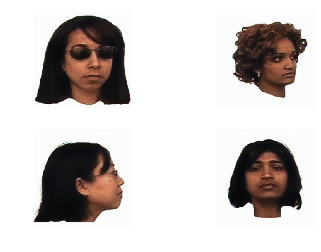

60/60 [==============================] - 1s 16ms/step
[0.0005941374809481203, 1.192093321833454e-07, 0.0005940182716585695]
60/60 [==============================] - 1s 16ms/step
[0.0005845394916832447, 1.192093321833454e-07, 0.0005844202823936939]
60/60 [==============================] - 1s 16ms/step
[0.0005998328677378594, 1.192093321833454e-07, 0.0005997136584483087]
60/60 [==============================] - 1s 16ms/step
[0.0007408362541658183, 1.192093321833454e-07, 0.0007407170448762675]
60/60 [==============================] - 1s 16ms/step
[0.0007240862081137797, 1.192093321833454e-07, 0.0007239669988242289]
60/60 [==============================] - 1s 16ms/step
[0.000660814872632424, 1.192093321833454e-07, 0.0006606956633428732]
60/60 [==============================] - 1s 16ms/step
[0.0006014907460970184, 1.192093321833454e-07, 0.0006013715368074676]
60/60 [==============================] - 1s 16ms/step
[0.0005901261776064833, 1.192093321833454e-07, 0.0005900069683169325]
60/60 [==

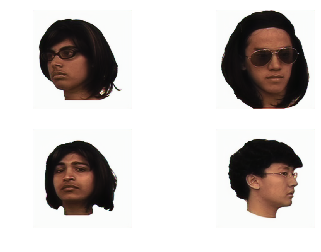

60/60 [==============================] - 1s 16ms/step
[0.0006174320393862823, 1.192093321833454e-07, 0.0006173128300967315]
60/60 [==============================] - 1s 16ms/step
[0.0006210513218926887, 1.192093321833454e-07, 0.0006209321126031379]
60/60 [==============================] - 1s 16ms/step
[0.0006794555694796145, 1.192093321833454e-07, 0.0006793363601900638]
60/60 [==============================] - 1s 16ms/step
[0.0005998466707145175, 1.192093321833454e-07, 0.0005997274614249667]
60/60 [==============================] - 1s 16ms/step
[0.0005906093982048332, 1.192093321833454e-07, 0.0005904901889152824]
60/60 [==============================] - 1s 16ms/step
[0.0005903306029116114, 1.192093321833454e-07, 0.0005902113936220606]
60/60 [==============================] - 1s 16ms/step
[0.0005859472750065227, 1.192093321833454e-07, 0.000585828065716972]
60/60 [==============================] - 1s 16ms/step
[0.0006100461857082943, 1.192093321833454e-07, 0.0006099269764187435]
60/60 [==

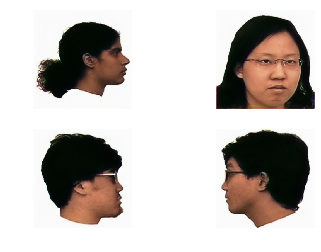

60/60 [==============================] - 1s 16ms/step
[0.0009565742181924482, 1.192093321833454e-07, 0.0009564550089028975]
60/60 [==============================] - 1s 16ms/step
[0.0006499009012865524, 1.192093321833454e-07, 0.0006497816919970016]
60/60 [==============================] - 1s 16ms/step
[0.0006055297989708681, 1.192093321833454e-07, 0.0006054105896813174]
60/60 [==============================] - 1s 16ms/step
[0.000764744794772317, 1.192093321833454e-07, 0.0007646255854827662]
60/60 [==============================] - 1s 16ms/step
[0.0008048000318619113, 1.192093321833454e-07, 0.0008046808225723605]
60/60 [==============================] - 1s 16ms/step
[0.0007311770808883011, 1.192093321833454e-07, 0.0007310578715987503]
60/60 [==============================] - 1s 16ms/step
[0.0005744491509782772, 1.192093321833454e-07, 0.0005743299416887264]
60/60 [==============================] - 1s 16ms/step
[0.000798719465577354, 1.192093321833454e-07, 0.0007986002562878033]
60/60 [===

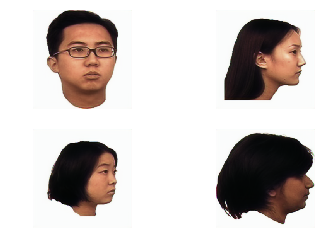

60/60 [==============================] - 1s 16ms/step
[0.0005835076716418068, 1.192093321833454e-07, 0.000583388462352256]
60/60 [==============================] - 1s 16ms/step
[0.0005989687633700669, 1.192093321833454e-07, 0.0005988495540805161]
60/60 [==============================] - 1s 16ms/step
[0.0006335156154818833, 1.192093321833454e-07, 0.0006333964061923325]
60/60 [==============================] - 1s 16ms/step
[0.000690388046981146, 1.192093321833454e-07, 0.0006902688376915952]
60/60 [==============================] - 1s 16ms/step
[0.0007129557547159493, 1.192093321833454e-07, 0.0007128365454263985]
60/60 [==============================] - 1s 16ms/step
[0.0006942483402478198, 1.192093321833454e-07, 0.000694129130958269]
60/60 [==============================] - 1s 16ms/step
[0.0006558011596401532, 1.192093321833454e-07, 0.0006556819503506024]
60/60 [==============================] - 1s 16ms/step
[0.0006001877559659381, 1.192093321833454e-07, 0.0006000685466763874]
60/60 [====

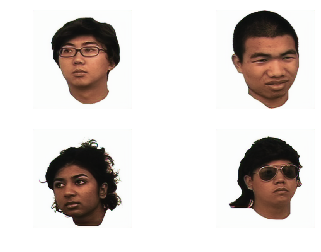

60/60 [==============================] - 1s 16ms/step
[0.000631579605396837, 1.192093321833454e-07, 0.0006314603961072862]
60/60 [==============================] - 1s 16ms/step
[0.0006857697037048638, 1.192093321833454e-07, 0.000685650494415313]
60/60 [==============================] - 1s 16ms/step
[0.0006976824913484355, 1.192093321833454e-07, 0.0006975632820588847]
60/60 [==============================] - 1s 16ms/step
[0.000669977666499714, 1.192093321833454e-07, 0.0006698584572101632]
60/60 [==============================] - 1s 16ms/step
[0.0006212990110119183, 1.192093321833454e-07, 0.0006211798017223676]
60/60 [==============================] - 1s 16ms/step
[0.000600264233071357, 1.192093321833454e-07, 0.0006001450237818062]
60/60 [==============================] - 1s 16ms/step
[0.0006011915199148158, 1.192093321833454e-07, 0.000601072310625265]
60/60 [==============================] - 1s 16ms/step
[0.000606421078555286, 1.192093321833454e-07, 0.0006063018692657352]
60/60 [=======

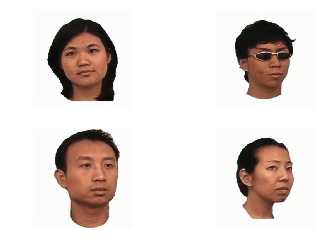

60/60 [==============================] - 1s 16ms/step
[0.00058904979377985, 1.192093321833454e-07, 0.0005889305844902992]
60/60 [==============================] - 1s 16ms/step
[0.0005535855966930588, 1.192093321833454e-07, 0.000553466387403508]
60/60 [==============================] - 1s 16ms/step
[0.0005485545572203894, 1.192093321833454e-07, 0.0005484353479308387]
60/60 [==============================] - 1s 16ms/step
[0.0005510439552987615, 1.192093321833454e-07, 0.0005509247460092107]
60/60 [==============================] - 1s 16ms/step
[0.0005800093989819288, 1.192093321833454e-07, 0.000579890189692378]
60/60 [==============================] - 1s 16ms/step
[0.0005965164784962932, 1.192093321833454e-07, 0.0005963972692067424]
60/60 [==============================] - 1s 16ms/step
[0.0005945228428269426, 1.192093321833454e-07, 0.0005944036335373918]
60/60 [==============================] - 1s 16ms/step
[0.0006412569084204734, 1.192093321833454e-07, 0.0006411376991309226]
60/60 [=====

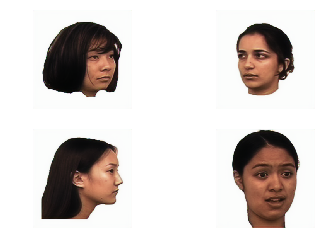

60/60 [==============================] - 1s 16ms/step
[0.0006044474197551608, 1.192093321833454e-07, 0.00060432821046561]
60/60 [==============================] - 1s 16ms/step
[0.0006411596317775547, 1.192093321833454e-07, 0.000641040422488004]
60/60 [==============================] - 1s 16ms/step
[0.0006480960990302264, 1.192093321833454e-07, 0.0006479768897406756]
60/60 [==============================] - 1s 16ms/step
[0.0007543542810405294, 1.192093321833454e-07, 0.0007542350717509787]
60/60 [==============================] - 1s 16ms/step
[0.0006700094207189977, 1.192093321833454e-07, 0.0006698902114294469]
60/60 [==============================] - 1s 16ms/step
[0.0005861880180115501, 1.192093321833454e-07, 0.0005860688087219993]
60/60 [==============================] - 1s 16ms/step
[0.0005358242546208203, 1.192093321833454e-07, 0.0005357050453312695]
60/60 [==============================] - 1s 16ms/step
[0.0005382006328242521, 1.192093321833454e-07, 0.0005380814235347013]
60/60 [====

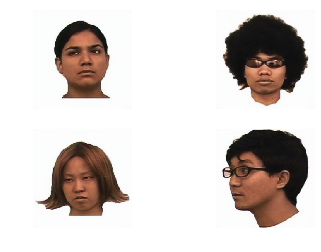

60/60 [==============================] - 1s 16ms/step
[0.0005506722062515716, 1.192093321833454e-07, 0.0005505529969620208]
60/60 [==============================] - 1s 16ms/step
[0.0005461811282051107, 1.192093321833454e-07, 0.0005460619189155599]
60/60 [==============================] - 1s 16ms/step
[0.0007479483688560625, 1.192093321833454e-07, 0.0007478291595665117]
60/60 [==============================] - 1s 16ms/step
[0.0008811722393147648, 1.192093321833454e-07, 0.000881053030025214]
60/60 [==============================] - 1s 16ms/step
[0.0009496312860089044, 1.192093321833454e-07, 0.0009495120767193536]
60/60 [==============================] - 1s 16ms/step
[0.0009681442209209005, 1.192093321833454e-07, 0.0009680250116313497]
60/60 [==============================] - 1s 16ms/step
[0.0006421959997775655, 1.192093321833454e-07, 0.0006420767904880147]
60/60 [==============================] - 1s 16ms/step
[0.0005155611802668621, 1.192093321833454e-07, 0.0005154419709773113]
60/60 [==

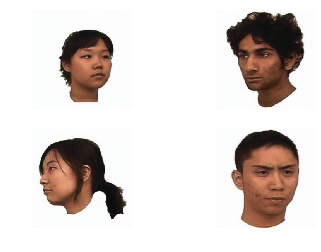

60/60 [==============================] - 1s 16ms/step
[0.0005370189940246443, 1.192093321833454e-07, 0.0005368997847350935]
60/60 [==============================] - 1s 16ms/step
[0.0005241664087710282, 1.192093321833454e-07, 0.0005240471994814774]
60/60 [==============================] - 1s 16ms/step
[0.0005990287483048936, 1.192093321833454e-07, 0.0005989095390153428]
60/60 [==============================] - 1s 16ms/step
[0.0005949131795205176, 1.192093321833454e-07, 0.0005947939702309668]
60/60 [==============================] - 1s 16ms/step
[0.0005795155807087819, 1.192093321833454e-07, 0.0005793963714192311]
60/60 [==============================] - 1s 16ms/step
[0.0005499071558006108, 1.192093321833454e-07, 0.00054978794651106]
60/60 [==============================] - 1s 16ms/step
[0.0005330104962922632, 1.192093321833454e-07, 0.0005328912870027125]
60/60 [==============================] - 1s 16ms/step
[0.0005630931816995143, 1.192093321833454e-07, 0.0005629739724099636]
60/60 [===

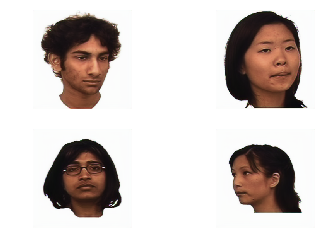

60/60 [==============================] - 1s 16ms/step
[0.0005195527104660868, 1.192093321833454e-07, 0.0005194335011765361]
60/60 [==============================] - 1s 16ms/step
[0.0005310751148499548, 1.192093321833454e-07, 0.0005309559055604041]
60/60 [==============================] - 1s 16ms/step
[0.0005902237685707708, 1.192093321833454e-07, 0.00059010455928122]
60/60 [==============================] - 1s 16ms/step
[0.0005462405077802638, 1.192093321833454e-07, 0.000546121298490713]
60/60 [==============================] - 1s 16ms/step
[0.0005185716940710942, 1.192093321833454e-07, 0.0005184524847815434]
60/60 [==============================] - 1s 16ms/step
[0.0005522887726935248, 1.192093321833454e-07, 0.000552169563403974]
60/60 [==============================] - 1s 16ms/step
[0.0005977851959566275, 1.192093321833454e-07, 0.0005976659866670768]
60/60 [==============================] - 1s 16ms/step
[0.0006081917633612951, 1.192093321833454e-07, 0.0006080725540717443]
60/60 [=====

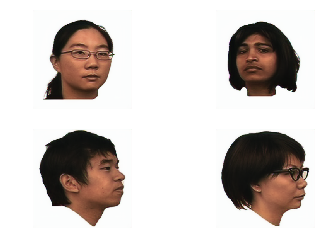

60/60 [==============================] - 1s 16ms/step
[0.0005379062301168839, 1.192093321833454e-07, 0.0005377870208273331]
60/60 [==============================] - 1s 16ms/step
[0.0006404404217998186, 1.192093321833454e-07, 0.0006403212125102679]
60/60 [==============================] - 1s 16ms/step
[0.0008000276400707662, 1.192093321833454e-07, 0.0007999084307812154]
60/60 [==============================] - 1s 16ms/step
[0.0008339392913815876, 1.192093321833454e-07, 0.0008338200820920368]
60/60 [==============================] - 1s 16ms/step
[0.0007398350435929994, 1.192093321833454e-07, 0.0007397158343034486]
60/60 [==============================] - 1s 16ms/step
[0.0007038173964247108, 1.192093321833454e-07, 0.00070369818713516]
60/60 [==============================] - 1s 16ms/step
[0.0005976469488814473, 1.192093321833454e-07, 0.0005975277395918966]
60/60 [==============================] - 1s 16ms/step
[0.0005815232133803268, 1.192093321833454e-07, 0.000581404004090776]
60/60 [====

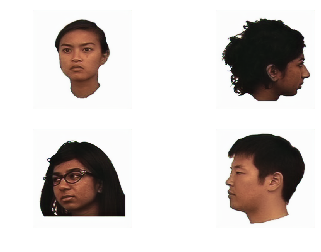

60/60 [==============================] - 1s 16ms/step
[0.0006077522799993554, 1.192093321833454e-07, 0.0006076330707098047]
60/60 [==============================] - 1s 16ms/step
[0.0005908708747786781, 1.192093321833454e-07, 0.0005907516654891273]
60/60 [==============================] - 1s 16ms/step
[0.0005733667213159303, 1.192093321833454e-07, 0.0005732475120263796]
60/60 [==============================] - 1s 16ms/step
[0.000571443730344375, 1.192093321833454e-07, 0.0005713245210548242]
60/60 [==============================] - 1s 16ms/step
[0.0005559206746208171, 1.192093321833454e-07, 0.0005558014653312663]
60/60 [==============================] - 1s 16ms/step
[0.0005373771224791805, 1.192093321833454e-07, 0.0005372579131896297]
60/60 [==============================] - 1s 16ms/step
[0.000525384652428329, 1.192093321833454e-07, 0.0005252654431387782]
60/60 [==============================] - 1s 16ms/step
[0.0005133016908075661, 1.192093321833454e-07, 0.0005131824815180153]
60/60 [===

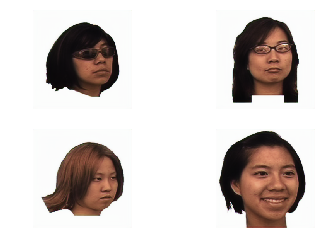

60/60 [==============================] - 1s 16ms/step
[0.0005419051352267464, 1.192093321833454e-07, 0.0005417859259371957]
60/60 [==============================] - 1s 16ms/step
[0.0005659427493810654, 1.192093321833454e-07, 0.0005658235400915146]
60/60 [==============================] - 1s 16ms/step
[0.0005619630333967507, 1.192093321833454e-07, 0.0005618438241071999]
60/60 [==============================] - 1s 16ms/step
[0.000515819990929837, 1.192093321833454e-07, 0.0005157007816402863]
60/60 [==============================] - 1s 16ms/step
[0.0004940312879625708, 1.192093321833454e-07, 0.00049391207867302]
60/60 [==============================] - 1s 16ms/step
[0.0005116935780582328, 1.192093321833454e-07, 0.000511574368768682]
60/60 [==============================] - 1s 16ms/step
[0.0005518142327976724, 1.192093321833454e-07, 0.0005516950235081216]
60/60 [==============================] - 1s 16ms/step
[0.0005622418636145691, 1.192093321833454e-07, 0.0005621226543250183]
60/60 [=====

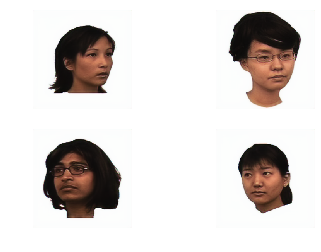

60/60 [==============================] - 1s 16ms/step
[0.0005380232391568522, 1.192093321833454e-07, 0.0005379040298673014]
60/60 [==============================] - 1s 16ms/step
[0.0005811133615983029, 1.192093321833454e-07, 0.0005809941523087521]
60/60 [==============================] - 1s 16ms/step
[0.0006280333346997698, 1.192093321833454e-07, 0.000627914125410219]
60/60 [==============================] - 1s 16ms/step
[0.0006685577953855197, 1.192093321833454e-07, 0.0006684385860959689]
60/60 [==============================] - 1s 16ms/step
[0.0006181784245806436, 1.192093321833454e-07, 0.0006180592152910928]
60/60 [==============================] - 1s 16ms/step
[0.0005314487886304656, 1.192093321833454e-07, 0.0005313295793409148]
60/60 [==============================] - 1s 16ms/step
[0.0005488595925271511, 1.192093321833454e-07, 0.0005487403832376003]
60/60 [==============================] - 1s 16ms/step
[0.0006635477533563971, 1.192093321833454e-07, 0.0006634285440668463]
60/60 [==

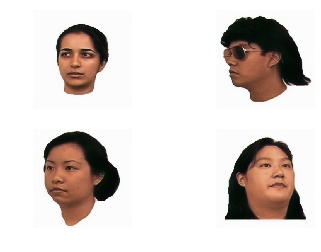

60/60 [==============================] - 1s 16ms/step
[0.0007349365740083158, 1.192093321833454e-07, 0.000734817364718765]
60/60 [==============================] - 1s 16ms/step
[0.0005655362542408208, 1.192093321833454e-07, 0.00056541704495127]
60/60 [==============================] - 1s 16ms/step
[0.0005244550683225195, 1.192093321833454e-07, 0.0005243358590329687]
60/60 [==============================] - 1s 16ms/step
[0.0005208759685046971, 1.192093321833454e-07, 0.0005207567592151463]
60/60 [==============================] - 1s 16ms/step
[0.0005176663359937569, 1.192093321833454e-07, 0.0005175471267042061]
60/60 [==============================] - 1s 16ms/step
[0.0005184482841286808, 1.192093321833454e-07, 0.00051832907483913]
60/60 [==============================] - 1s 16ms/step
[0.0005176784722910573, 1.192093321833454e-07, 0.0005175592630015065]
60/60 [==============================] - 1s 16ms/step
[0.0005061064206529408, 1.192093321833454e-07, 0.0005059872113633901]
60/60 [======

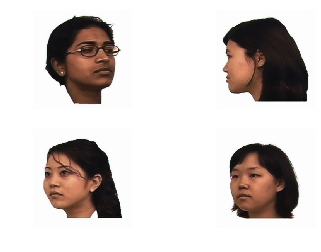

60/60 [==============================] - 1s 16ms/step
[0.0005176489804095279, 1.192093321833454e-07, 0.0005175297711199771]
60/60 [==============================] - 1s 16ms/step
[0.0006082130634846787, 1.192093321833454e-07, 0.0006080938541951279]
60/60 [==============================] - 1s 16ms/step
[0.0007519858540035784, 1.192093321833454e-07, 0.0007518666447140276]
60/60 [==============================] - 1s 16ms/step
[0.0008518319460563362, 1.192093321833454e-07, 0.0008517127367667854]
60/60 [==============================] - 1s 16ms/step
[0.0007702079562780758, 1.192093321833454e-07, 0.000770088746988525]
60/60 [==============================] - 1s 16ms/step
[0.0005844110118535657, 1.192093321833454e-07, 0.0005842918025640149]
60/60 [==============================] - 1s 16ms/step
[0.0005125786139008899, 1.192093321833454e-07, 0.0005124594046113392]
60/60 [==============================] - 1s 16ms/step
[0.0004893690561099599, 1.192093321833454e-07, 0.0004892498468204091]
60/60 [==

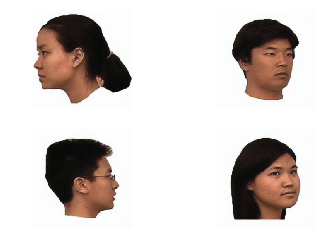

60/60 [==============================] - 1s 16ms/step
[0.00047395530079180994, 1.192093321833454e-07, 0.00047383609150225916]
60/60 [==============================] - 1s 16ms/step
[0.00046946430617632963, 1.192093321833454e-07, 0.00046934509688677885]
60/60 [==============================] - 1s 16ms/step
[0.0004744210784944395, 1.192093321833454e-07, 0.0004743018692048887]
60/60 [==============================] - 1s 16ms/step
[0.0004783743041722725, 1.192093321833454e-07, 0.0004782550948827217]
60/60 [==============================] - 1s 16ms/step
[0.0004964856081642211, 1.192093321833454e-07, 0.0004963663988746703]
60/60 [==============================] - 1s 16ms/step
[0.0005190595014331242, 1.192093321833454e-07, 0.0005189402921435734]
60/60 [==============================] - 1s 16ms/step
[0.00047575337812304496, 1.192093321833454e-07, 0.0004756341688334942]
60/60 [==============================] - 1s 16ms/step
[0.0004980433887491624, 1.192093321833454e-07, 0.0004979241794596116]
60/

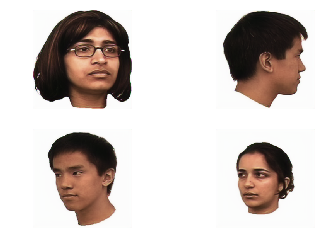

60/60 [==============================] - 1s 16ms/step
[0.000516729000567769, 1.192093321833454e-07, 0.0005166097912782182]
60/60 [==============================] - 1s 16ms/step
[0.00047595271413835384, 1.192093321833454e-07, 0.00047583350484880306]
60/60 [==============================] - 1s 16ms/step
[0.0004776095777439574, 1.192093321833454e-07, 0.00047749036845440664]
60/60 [==============================] - 1s 16ms/step
[0.00047422821323076886, 1.192093321833454e-07, 0.0004741090039412181]
60/60 [==============================] - 1s 16ms/step
[0.0004754117845247189, 1.192093321833454e-07, 0.00047529257523516814]
60/60 [==============================] - 1s 16ms/step
[0.0005553090401614705, 1.192093321833454e-07, 0.0005551898308719198]
60/60 [==============================] - 1s 16ms/step
[0.0006175969184065859, 1.192093321833454e-07, 0.0006174777091170351]
60/60 [==============================] - 1s 16ms/step
[0.0005585222427422802, 1.192093321833454e-07, 0.0005584030334527294]
60/6

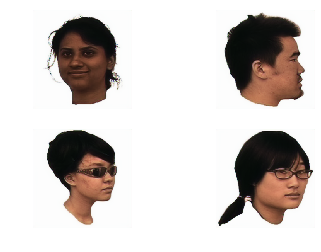

60/60 [==============================] - 1s 16ms/step
[0.00045487070844198266, 1.192093321833454e-07, 0.0004547514991524319]
60/60 [==============================] - 1s 16ms/step
[0.00046068280741261937, 1.192093321833454e-07, 0.0004605635981230686]
60/60 [==============================] - 1s 16ms/step
[0.0005016282569461813, 1.192093321833454e-07, 0.0005015090476566305]
60/60 [==============================] - 1s 16ms/step
[0.0005044121023577949, 1.192093321833454e-07, 0.0005042928930682441]
60/60 [==============================] - 1s 16ms/step
[0.0004884372639935464, 1.192093321833454e-07, 0.0004883180547039956]
60/60 [==============================] - 1s 16ms/step
[0.0004910275902754317, 1.192093321833454e-07, 0.0004909083809858809]
60/60 [==============================] - 1s 16ms/step
[0.00047775816832048196, 1.192093321833454e-07, 0.0004776389590309312]
60/60 [==============================] - 1s 16ms/step
[0.000464425878211235, 1.192093321833454e-07, 0.0004643066689216842]
60/60 

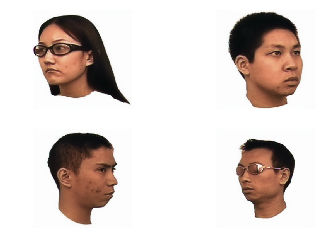

60/60 [==============================] - 1s 16ms/step
[0.0004789199680089951, 1.192093321833454e-07, 0.0004788007587194443]
60/60 [==============================] - 1s 16ms/step
[0.0004851095164970805, 1.192093321833454e-07, 0.00048499030720752974]
60/60 [==============================] - 1s 16ms/step
[0.00047831013992739223, 1.192093321833454e-07, 0.00047819093063784145]
60/60 [==============================] - 1s 16ms/step
[0.0004821348780145248, 1.192093321833454e-07, 0.000482015668724974]
60/60 [==============================] - 1s 16ms/step
[0.0004896040365565569, 1.192093321833454e-07, 0.0004894848272670061]
60/60 [==============================] - 1s 16ms/step
[0.0005215146966899435, 1.192093321833454e-07, 0.0005213954874003927]
60/60 [==============================] - 1s 16ms/step
[0.0005189986356223623, 1.192093321833454e-07, 0.0005188794263328115]
60/60 [==============================] - 1s 16ms/step
[0.0004926054175787915, 1.192093321833454e-07, 0.0004924862082892408]
60/60 

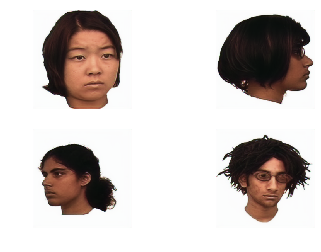

60/60 [==============================] - 1s 16ms/step
[0.0006394343334250152, 1.192093321833454e-07, 0.0006393151241354644]
60/60 [==============================] - 1s 16ms/step
[0.0007620433617072801, 1.192093321833454e-07, 0.0007619241524177293]
60/60 [==============================] - 1s 16ms/step
[0.0008286276832222938, 1.192093321833454e-07, 0.000828508473932743]
60/60 [==============================] - 1s 16ms/step
[0.0006939781635689239, 1.192093321833454e-07, 0.0006938589542793731]
60/60 [==============================] - 1s 16ms/step
[0.0005693423949802916, 1.192093321833454e-07, 0.0005692231856907408]
60/60 [==============================] - 1s 16ms/step
[0.0005393000241989891, 1.192093321833454e-07, 0.0005391808149094383]
60/60 [==============================] - 1s 16ms/step
[0.000575453438796103, 1.192093321833454e-07, 0.0005753342295065523]
60/60 [==============================] - 1s 16ms/step
[0.0006039117695763707, 1.192093321833454e-07, 0.0006037925602868199]
60/60 [===

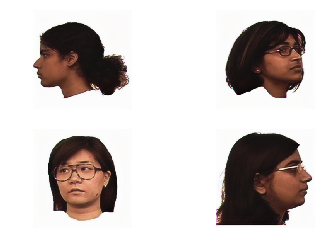

60/60 [==============================] - 1s 16ms/step
[0.0007994645236370464, 1.192093321833454e-07, 0.0007993453143474956]
60/60 [==============================] - 1s 16ms/step
[0.0007927856058813632, 1.192093321833454e-07, 0.0007926663965918124]
60/60 [==============================] - 1s 16ms/step
[0.0006406591351454456, 1.192093321833454e-07, 0.0006405399258558949]
60/60 [==============================] - 1s 16ms/step
[0.0005115369451232255, 1.192093321833454e-07, 0.0005114177358336747]
60/60 [==============================] - 1s 16ms/step
[0.0004861719227240731, 1.192093321833454e-07, 0.00048605271343452234]
60/60 [==============================] - 1s 16ms/step
[0.0005427421613906821, 1.192093321833454e-07, 0.0005426229521011313]
60/60 [==============================] - 1s 16ms/step
[0.0006025864393450319, 1.192093321833454e-07, 0.0006024672300554812]
60/60 [==============================] - 1s 16ms/step
[0.0006542432548788687, 1.192093321833454e-07, 0.0006541240455893179]
60/60 [

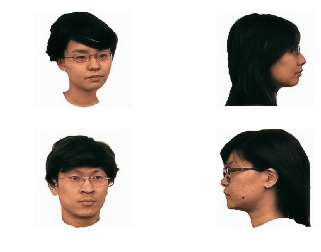

60/60 [==============================] - 1s 16ms/step
[0.0008992941196387013, 1.192093321833454e-07, 0.0008991749103491505]
60/60 [==============================] - 1s 16ms/step
[0.0007170456228777766, 1.192093321833454e-07, 0.0007169264135882258]
60/60 [==============================] - 1s 16ms/step
[0.0005448525732693573, 1.192093321833454e-07, 0.0005447333639798065]
60/60 [==============================] - 1s 16ms/step
[0.00048499306625065706, 1.192093321833454e-07, 0.0004848738569611063]
60/60 [==============================] - 1s 16ms/step
[0.0005111316723438601, 1.192093321833454e-07, 0.0005110124630543093]
60/60 [==============================] - 1s 16ms/step
[0.0005293268943205476, 1.192093321833454e-07, 0.0005292076850309968]
60/60 [==============================] - 1s 16ms/step
[0.0005418335630868872, 1.192093321833454e-07, 0.0005417143537973364]
60/60 [==============================] - 1s 16ms/step
[0.0006290834785128633, 1.192093321833454e-07, 0.0006289642692233126]
60/60 [

In [0]:
save_interval = 10
weight_path = "best_weights_generator"

d_losses_fake = []
d_losses_real = []
d_losses = []
g_losses = []

min_mse_loss = 10000
val_losses = []

for epoch in range(epochs):
  # Adversarial ground truths
  valid = np.ones((batch_size, 1)) #np.random.uniform(0.7, 1.0, batch_size) 
  fake =  np.zeros((batch_size, 1)) #np.random.uniform(0.0, 0.3, batch_size) 
  
  ## 
  # Train discriminator activation='sigmoid'))          
  
  # Select a random batch of images
  idx_rgb = np.random.randint(0, imgs_rgb_train.shape[0], batch_size)
  idx_gs = np.random.randint(0, imgs_rgb_train.shape[0], batch_size)

  batch_rgb = imgs_rgb_train[idx_rgb]

  #idx = np.random.randint(0, imgs_rgb_train.shape[0], batch_size)
  batch_gs = imgs_gs_train[idx_gs]

  # Generate a batch of new images
  gen_imgs = generator.predict(batch_gs)

  # Run training on discrimantor
  d_loss_real = discriminator.train_on_batch(batch_rgb, valid)
  d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
  
  d_losses_fake.append(d_loss_fake)
  d_losses_real.append(d_loss_real)
  d_losses.append(d_loss)
  
  ##
  # Train generator

  idx_a = np.random.randint(0, imgs_rgb_train.shape[0], batch_size)
  #noise = np.random.normal(0, 1, (batch_size, noise_dim))
  g_loss = adversarial.train_on_batch(imgs_gs_train[idx_a], [valid, imgs_rgb_train[idx_a]])
  g_losses.append(g_loss)
  
  valid_val = np.ones((60, 1))
  val_loss = adversarial.evaluate(imgs_gs_val, [valid_val, imgs_rgb_val])
  
  
  print(val_loss)
  if (val_loss[0] < min_mse_loss):
    generator.save_weights(weight_path)
    min_mse_loss = val_loss[0]
    val_losses.append(val_loss)
    
  if epoch % save_interval == 0:
    print("d_real:", d_loss_real)
    print("d_fake:", d_loss_fake)
    
    # Plot the progress
    print ("%d/%d [D loss: %f, acc.: %.2f%%] [G loss mse: %f] [G loss bce: %f]" % 
         (epoch, epochs, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))
    
    idx_gs = np.random.randint(0, imgs_rgb_train.shape[0], 4)
    batch_gs = imgs_gs_train[idx_gs]
    # show images if at save interval
    sample_images(epoch, generator, batch_gs)

## Model evaluation

## Loss_curves

The chart bellow is hard to analyse and it can drastically change for each training that I run. Though, the only thing that is plotted here is the adversarial loss. It really doesn't make sense to me.

[[0.5856209, 0.625], [2.014762, 0.875], [3.022143, 0.8125], [1.0073811, 0.9375], [1.0073811, 0.9375], [3.022143, 0.8125], [5.036905, 0.6875], [5.036905, 0.6875], [5.036905, 0.6875], [2.014762, 0.875], [3.022143, 0.8125], [4.029524, 0.75], [5.036905, 0.6875], [4.029524, 0.75], [1.1920933e-07, 1.0], [1.0073811, 0.9375], [2.014762, 0.875], [1.0073811, 0.9375], [1.1920933e-07, 1.0], [2.014762, 0.875], [1.0073811, 0.9375], [1.0073811, 0.9375], [2.014762, 0.875], [1.0073811, 0.9375], [3.022143, 0.8125], [3.022143, 0.8125], [4.029524, 0.75], [4.029524, 0.75], [4.029524, 0.75], [1.0073811, 0.9375], [2.014762, 0.875], [3.022143, 0.8125], [4.029524, 0.75], [5.036905, 0.6875], [3.022143, 0.8125], [3.022143, 0.8125], [7.0516667, 0.5625], [2.014762, 0.875], [3.022143, 0.8125], [4.029524, 0.75], [5.036905, 0.6875], [4.029524, 0.75], [1.0073811, 0.9375], [5.036905, 0.6875], [2.014762, 0.875], [3.022143, 0.8125], [3.022143, 0.8125], [1.0073811, 0.9375], [2.014762, 0.875], [4.029524, 0.75], [4.029524, 

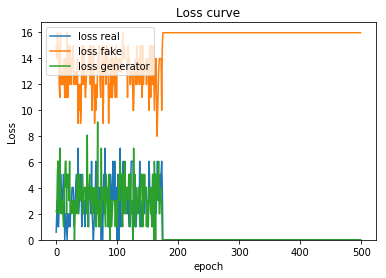

In [0]:
import matplotlib.pyplot as plt

print(d_losses_real)
np_d_losses_real = np.array(d_losses_real)
np_d_losses_fake = np.array(d_losses_fake)
np_d_losses = np.array(d_losses)
np_g_losses = np.array(g_losses)
np_val_losses = np.array(val_losses)

# Plot curve for loss
plt.plot(np_d_losses_real[:,0])
plt.plot(np_d_losses_fake[:,0])
plt.plot(np_g_losses[:,0])
plt.title('Loss curve')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['loss real', 'loss fake', 'loss generator', 'val_loss'], loc='upper left')
plt.ylim(bottom=0)
plt.show()

# Val loss

We can notice from the chart bellow that the validation error is deacrising which makes sense here.

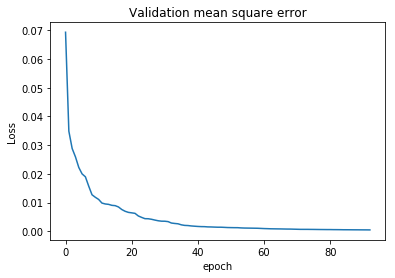

In [0]:
plt.plot(np_val_losses[:,0])
plt.title("Validation mean square error")
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

# Model Accuracy

We fixed arbitrarily a threshold of 0.02 (SAD) two separate good and bad colorization. With this threshold we have 249 grayscale images "correctly" colorized and 8 that are badly colorized. We tried using image correlation but it just takes too much time to compute on the whole test set.

In [0]:
from skimage.feature import match_template

copy_generator = generator
generator.load_weights(weight_path)
gen_rgb_images = generator.predict(imgs_gs_test)


# Takes too much time
#correlations = []
#for i in range(gen_rgb_images.shape[0]):
#  sum = np.sum(match_template(gen_rgb_images[i], imgs_rgb_test[i]))
#  correlations.append(sum)

absolute_diff = np.abs(gen_rgb_images - imgs_rgb_test) / (img_width * img_height)
sad = np.sum(absolute_diff, axis=(1,2,3)) / 3

# Arbitrary thereshold for separating bad and good colorization
thresh = 0.02
good_colorization = len(sad[sad < thresh])

print("Number of good colorization:", good_colorization)
print("Number of bad colorization:", len(sad) - good_colorization)

print("----")

#print(good_colorization)
#print(sad)

Number of good colorization: 249
Number of bad colorization: 8
----


# Good and bad examples

In [0]:
i_top3_bad = sad.argsort()[-3:]
i_top3_good = sad.argsort()[:3]

# Show the 3 best exampes

Here we show the top 3 best colorized images. It can be seen that the best generation are done when people on the images have black hair and don't wear glasses.

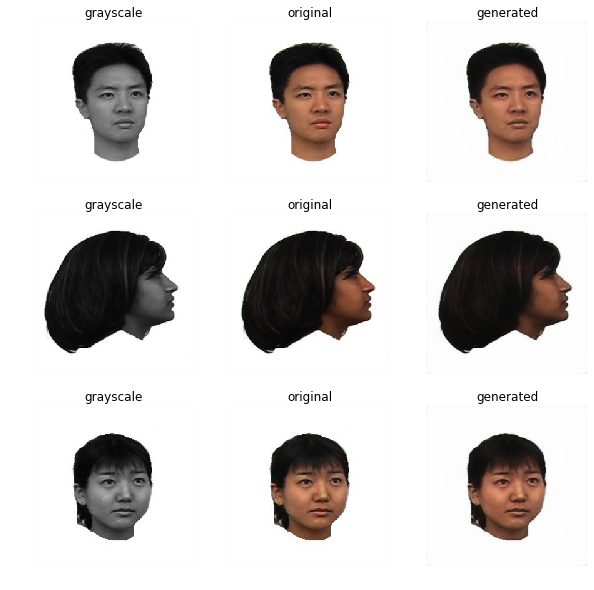

In [0]:
fig, axis = plt.subplots(3, 3, sharey=True, figsize=(10,10))
cnt = 0
for i in i_top3_good:
  axis[cnt,0].imshow(imgs_gs_test[i, :, :,0], cmap='gray')
  axis[cnt,0].axis('off')
  axis[cnt,0].set_title('grayscale')
  
  axis[cnt,1].imshow(imgs_rgb_test[i, :, :,])
  axis[cnt,1].axis('off')
  axis[cnt,1].set_title('original')
  
  axis[cnt,2].imshow(gen_rgb_images[i, :, :,])
  axis[cnt,2].axis('off')
  axis[cnt,2].set_title('generated')
  
  cnt += 1
plt.show()
plt.close()

# Show the 3 worse exampes

In the contrary, Our generator struggle to colorize images that include people having colored hair and/or wearing glasses. But that totally make sense and overall we can say we have very good looking results.

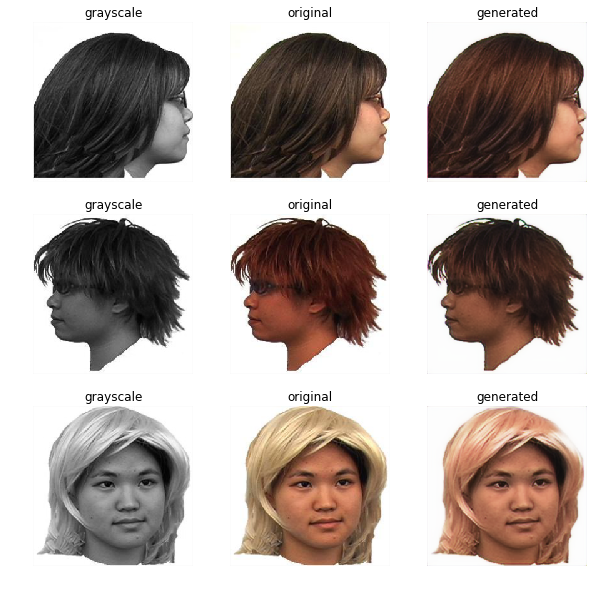

In [0]:
fig, axis = plt.subplots(3, 3, sharey=True, figsize=(10,10))
cnt = 0
for i in i_top3_bad:
  axis[cnt,0].imshow(imgs_gs_test[i, :, :,0], cmap='gray')
  axis[cnt,0].axis('off')
  axis[cnt,0].set_title('grayscale')
  
  axis[cnt,1].imshow(imgs_rgb_test[i, :, :,])
  axis[cnt,1].axis('off')
  axis[cnt,1].set_title('original')
  
  axis[cnt,2].imshow(gen_rgb_images[i, :, :,])
  axis[cnt,2].axis('off')
  axis[cnt,2].set_title('generated')
  
  cnt += 1
plt.show()
plt.close()

# Save best model in my Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#!ls "/content/drive/My Drive"
TP_DL_dir = "/content/drive/My\ Drive/TP_DL"

BEST_WEIGHTS = (TP_DL_dir + "/generator_asian_weights.hd5").replace('\ ', ' ')
BEST_MODEL = (TP_DL_dir + "/generator_asian_model.hd5").replace('\ ', ' ')

print(BEST_MODEL)

generator.save_weights(BEST_WEIGHTS)
generator.save(BEST_MODEL)

!ls {TP_DL_dir}

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/TP_DL/generator_asian_model.hd5
densenet_model.hd5	     mobilenetv2_weights.hd5
densenet_weights.hd5	     own_model.hd5
FaceData.csv		     own_model_weights.hd5
FacesDataset.zip	     vgg_no_transfert_best_model.hd5
generator_asian_model.hd5    vgg_no_transfert_best_weights.hd5
generator_asian_weights.hd5  vgg_transfert_best_model.hd5
mobilenetv2_model.hd5	     vgg_transfert_best_weights.hd5
